# Predicting Citation Scores of Astrophysics Publications

In [4]:
# Import
import time
import itertools
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ads
import ast
from iteration_utilities import deepflatten
from nltk.tokenize import RegexpTokenizer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve 
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

# Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Secrets file
import secrets

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ADS API

In [5]:
# ADS API token: https://ui.adsabs.harvard.edu/help/api/
token = secrets.ADS_API_TOKEN # from secrets
ads.config.token = token

author, affiliation, title, abstract
randomly download 10,000 articles

highest citations
2001: 6570
2002: 6619
2003: 11118
2004: 19110
2005: 9874

In [3]:
# Set seed
random.seed(2448)
np.random.seed(2448)

Data Collection

In [4]:
# Collect 5 years of publications
# Roughly 15 years ago for static citation count
years = [2001, 2002, 2003, 2004, 2005]
dfs = []

In [5]:
# Set parameters for lo and hi citations
for year in years:
    loCite = [0, 40, 80, 400]
    hiCite = [10, 50, 100, 6000]

    # Query ADS with eight parameters
    # Randomly collect 500 papers in each lo-hi range for each of five years
    # Collect 10,000 papers total
    for (l, h) in zip(loCite, hiCite):
        q = ads.SearchQuery(q='year:'+str(year)+ " citation_count:[%d TO %d]"%(l, h), fl=['id', 'year', 'bibcode', 'title', 'citation_count', 'author', 'abstract', 'aff'], rows = 500)
        q.execute()
        df = pd.DataFrame.from_dict(q.response.json['response']['docs'])
        dfs.append(df)

Dataframe

In [6]:
# Create Pandas dataframe
for d in range(len(dfs)):
    df = dfs[d]
    df['title'] = df['title'].astype(str)
    df['author'] = df['author'].astype(str)
    df['aff'] = df['aff'].astype(str)

l1 = []
l2 = []
l3 = []
l4 = []

ll = [l1, l2, l3, l4]

for d in range(len(dfs)):
    df = dfs[d]
    x = df['citation_count'].to_list()
    ll[d%4].append(x)

Citation Histograms

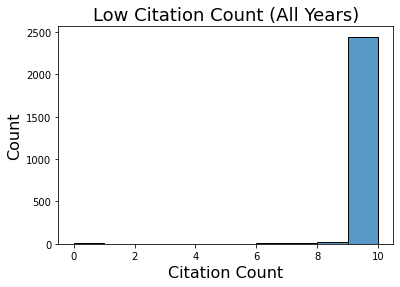

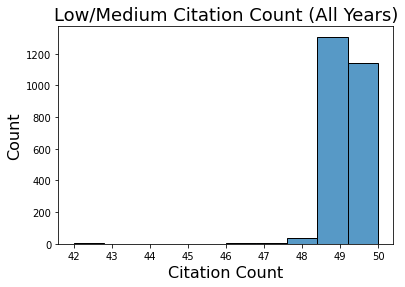

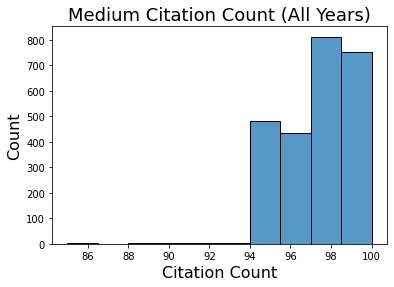

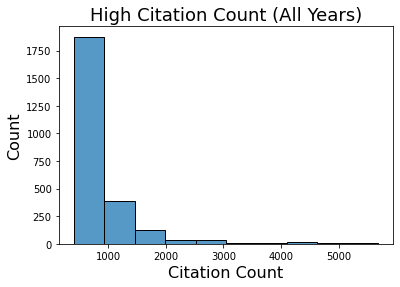

<Figure size 432x288 with 0 Axes>

In [7]:
# Citation count distribution
titles = ['Low Citation Count (All Years)', 'Low/Medium Citation Count (All Years)', 'Medium Citation Count (All Years)', 'High Citation Count (All Years)']
names = ['low.png', 'lm.png', 'med.png', 'high.png']

for dind in range(len(ll)):
    d = ll[dind]
    pl = sns.histplot(list(deepflatten(d)), bins=10)
    plt.xlabel('Citation Count', fontsize = 16)
    plt.ylabel('Count', fontsize = 16)
    plt.title(titles[dind], fontsize = 18)
    plt.savefig(names[dind])
    plt.show()
    plt.clf()

In [8]:
merge_df = dfs[0]
for d in range(1, len(dfs)):
    merge_df = pd.merge(merge_df, dfs[d], how='outer')

# To CSV
merge_df.to_csv('paper_dataframe.csv')

SVR Models

In [9]:
# Add stopwords
stopWords = stopwords.words('english')

Performing affiliation word minimum thresholding
['centre', 'theoretical', 'studies', 'indian', 'institute', 'science', 'bangalore', '560', 'UNK', 'india']
Performing author word minimum thresholding
['UNK', 'r', 'g', 'ali', 'yamamoto', 'satoshi', 'hiroyuki', 'ikeda', 'ito', 'saito']
Prepping Pipeline
(10000, 5801)
Running Pipeline
R-squared: -0.16439109187883383
MSE: 232344.18949749044


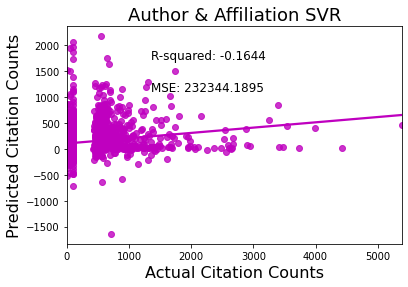

<Figure size 432x288 with 0 Axes>

In [10]:
###############
### Model A ###
###############

# Load data
merge_df = pd.read_csv('paper_dataframe.csv')
# Define Regexp tokenizer that grabs only words and discards punctuation and spaces
tok = RegexpTokenizer(r'\w+')

# Collect vocabulary from affiliation data
# Tokenize affiliations 
affs = []
for aff in merge_df.aff:
    for a in tok.tokenize(aff): 
        affs.append(a.lower()) 

# Filtering of rare words using Counter function
min_token_freq = 10
words_countdict = dict(Counter(affs))
print("Performing affiliation word minimum thresholding")

for a in range(len(affs)):
    aff = affs[a]
    if words_countdict[aff] < min_token_freq: 
        affs[a] = 'UNK'

# Do final vocabulary assignment, filtering Stop Words and repeats
affvocab = []
for aff in affs: 
    if aff not in affvocab and aff not in stopWords:
        affvocab.append(aff)

# Show examples of vocabulary words        
print(affvocab[:10])

# Collect author vocabulary words
# Tokenize authors
authors = []
for auth in merge_df.author:
    for a in tok.tokenize(auth):
        authors.append(a.lower())

# Do rare word downselection of author words
words_countdict = dict(Counter(authors))
print("Performing author word minimum thresholding")
for a in range(len(authors)):
    auth = authors[a]
    if words_countdict[auth] < min_token_freq: 
        authors[a] = 'UNK'


# Do final filtering of author vocabulary, taking out stop words
authorvocab = []
for auth in authors: 
    if auth not in authorvocab and auth not in stopWords: 
        authorvocab.append(auth)

print(authorvocab[:10])

# Load up input data into binary matrix
print('Prepping Pipeline')
x = np.zeros((len(merge_df.citation_count), len(affvocab) + len(authorvocab)), dtype=np.int8)
print(np.shape(x))

for i in range(len(merge_df.aff)): 

    for v in range(len(affvocab)): 
        if affvocab[v] in merge_df.aff[i]:
            x[i][v] = 1   
            
    for v in range(len(authorvocab)): 
        if authorvocab[v] in merge_df.author[i]:
            x[i][v + len(affvocab)] = 1

y = merge_df.citation_count
X = x

# Split data into testing and training using built in functionality
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X, y, random_state=0)

print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_A, y_train_A)

# Apply model to test data and quantify model performance
y_test_fit_A = pipe.predict(X_test_A)
score_A = r2_score(y_test_A, y_test_fit_A)
mse_A = mean_squared_error(y_test_A, y_test_fit_A)
print("R-squared:", score_A)
print("MSE:", mse_A)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_A, y_test_fit_A, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_A), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_A), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Author & Affiliation SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrAffiliationC1.png')
plt.show()
plt.clf()

Performing title word minimum thresholding
['UNK', 'sub', 'sup', 'e', 'magnetic', 'symmetric', 'instability', 'observation', 'c', '3']
['In this talk I briefly summarize different models for σ2γtot (e<SUP>+</SUP>e<SUP>-</SUP>→γγ→hadrons) and contrast model predictions with the data. I will then discuss the capability of the future e<SUP>+</SUP>e<SUP>-</SUP> and γγ colliders to distinguish between various models and end with an outlook for future work.', 'This paper explores magnetic equilibria which could result from the kink instability in a cylindrical magnetic flux tube. We examine a variety of cylindrical magnetic equilibria which are susceptible to the kink, and simulate its evolution in a frictional fluid. We assume that the evolution takes place under conditions of helical symmetry, so the problem becomes effectively two-dimensional. The initial cylindrical equilibrium field is specified in terms of its twist function k(r) = B/(rBz) and for a variety of k(r) functions we calcula

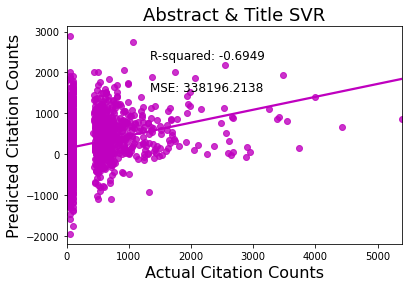

<Figure size 432x288 with 0 Axes>

In [11]:
###############
### Model P ###
###############

# Define Regexp tokenizer that grabs only words and discards punctuation and spaces
# Collect titles
# Tokenize titles
tok = RegexpTokenizer(r'\w+')
titles = []
for title in merge_df.title:
    for t in tok.tokenize(title): #title:
        titles.append(t.lower()) #doing letters instead of words?  

# Do rare word downselection
words_countdict = dict(Counter(titles))
print("Performing title word minimum thresholding")
for t in range(len(titles)):
    titleword = titles[t]
    if words_countdict[titleword] < min_token_freq: 
        titles[t] = 'UNK'

# Do final filtering of title vocabulary, taking out stop words
titlevocab = []
for title in titles: 
    if title not in titlevocab and title not in stopWords: 
        titlevocab.append(title)

print(titlevocab[:10])

# Cast abstracts as strings
abstracts = []
for abstract in merge_df.abstract:
    abstracts.append(str(abstract)) 

print(abstracts[:3])

# Collect abstract strings
# Tokenize abstracts here into list of all words for thresholding before vocabulary creation
abstractwords = []
for abstract in abstracts: 
    for a in tok.tokenize(abstract):
        abstractwords.append(a.lower())

# Do rare word downselection
words_countdict = dict(Counter(abstractwords))
print("Performing abstract word minimum thresholding")
for a in range(len(abstractwords)):
    absword = abstractwords[a]
    if words_countdict[absword] < min_token_freq: 
        abstractwords[a] = 'UNK'

# Do final filtering of abstract vocabulary, taking out stop words
abstractvocab = []
for a in abstractwords:
    if a not in abstractvocab and a not in stopWords: 
        abstractvocab.append(a)

print(abstractvocab[:10])

# Load up input data into binary matrix
print('Prepping Pipeline')
x = np.zeros((len(merge_df.citation_count), len(titlevocab) + len(abstractvocab)), dtype=np.int8)
print(np.shape(x))

for i in range(len(merge_df.aff)): 
    for v in range(len(titlevocab)): 
        if titlevocab[v] in merge_df.title[i]:
            x[i][v] = 1    

    for v in range(len(abstractvocab)): 
        if abstractvocab[v] in str(merge_df.abstract[i]):
            x[i][v + len(titlevocab)] = 1

y = merge_df.citation_count
X = x

# Split data into testing and training using built in functionality
X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(X, y, random_state=0)

print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_P, y_train_P)

# Apply model to test data and quantify model performance
y_test_fit_P = pipe.predict(X_test_P)
score_P = r2_score(y_test_P, y_test_fit_P)
mse_P = mean_squared_error(y_test_P, y_test_fit_P)
print("R-squared:", score_P)
print("MSE:", mse_P)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_P, y_test_fit_P, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_P), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_P), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Abstract & Title SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrPaperC1.png')
plt.show()
plt.clf()

Prepping Pipeline
(10000, 15843)
Running Pipeline
R-squared: -0.6721183640083888
MSE: 333656.78313676646


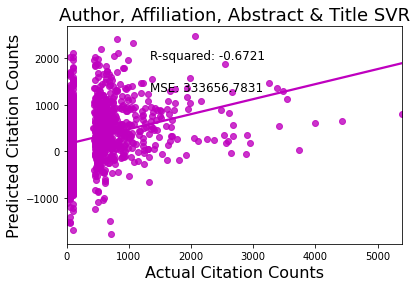

<Figure size 432x288 with 0 Axes>

In [12]:
################
### Model AP ###
################

print('Prepping Pipeline')

# Create matrix by checking each vocabulary word against each instance of that data 
x = np.zeros((len(merge_df.citation_count), len(affvocab) + len(authorvocab) + len(titlevocab) + len(abstractvocab)), dtype=np.int8)
print(np.shape(x))

for i in range(len(merge_df.aff)): 
    
    for v in range(len(affvocab)): 
        if affvocab[v] in merge_df.aff[i]:
            x[i][v] = 1
            
    for v in range(len(authorvocab)): 
        if authorvocab[v] in merge_df.author[i]:
            x[i][v + len(affvocab)] = 1


    for v in range(len(titlevocab)): 
        if titlevocab[v] in merge_df.title[i]:
            x[i][v + len(affvocab) + len(authorvocab)] = 1
            
    for v in range(len(abstractvocab)): 
        if abstractvocab[v] in str(merge_df.abstract[i]):
            x[i][v + len(affvocab) + len(authorvocab) + len(titlevocab)] = 1
            
y = merge_df.citation_count
X = x

# Split data into testing and training using built in functionality
X_train_AP, X_test_AP, y_train_AP, y_test_AP = train_test_split(X, y, random_state=0)

print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='linear', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_AP, y_train_AP)

# Apply model to test data and quantify model performance
y_test_fit_AP = pipe.predict(X_test_AP)
score_AP = r2_score(y_test_AP, y_test_fit_AP)
mse_AP = mean_squared_error(y_test_AP, y_test_fit_AP)
print("R-squared:", score_AP)
print("MSE:", mse_AP)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_AP, y_test_fit_AP, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Author, Affiliation, Abstract & Title SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrAffiliationPaperC1.png')
plt.show()
plt.clf()

Baseline Models

R-squared: -44.21910926435352
MSE: 9023082.85


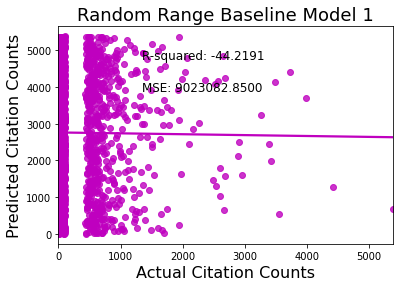

<Figure size 432x288 with 0 Axes>

In [13]:
#########################
#### Baseline model 1 ###
#########################

# Random citation count between 0 - max citation
y_test_bl1_AP = np.random.randint(0, max(y_test_AP) + 1, len(y_test_AP))

score_bl1_AP = r2_score(y_test_AP, y_test_bl1_AP)
mse_bl1_AP = mean_squared_error(y_test_AP, y_test_bl1_AP)

print("R-squared:", score_bl1_AP)
print("MSE:", mse_bl1_AP)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_AP, y_test_bl1_AP, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_bl1_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_bl1_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Random Range Baseline Model 1', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrBaseline1.png')
plt.show()
plt.clf()

[(10, 629)]
R-squared: -0.27741956166137594
MSE: 254898.0448


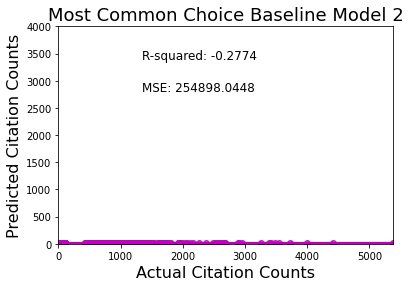

<Figure size 432x288 with 0 Axes>

In [14]:
#########################
### Baseline model 2 ###
#########################

# Citation count is always equal to the most common entry across all citation counts
countCitations = Counter(y_test_AP)
mostCommonCite = countCitations.most_common(1)
print(mostCommonCite)
y_test_bl2_AP = int(mostCommonCite[0][0])*np.ones(len(y_test_AP), dtype=int)

score_bl2_AP = r2_score(y_test_AP, y_test_bl2_AP)
mse_bl2_AP = mean_squared_error(y_test_AP, y_test_bl2_AP)

print("R-squared:", score_bl2_AP)
print("MSE:", mse_bl2_AP)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_AP, y_test_bl2_AP, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_bl2_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_bl2_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Most Common Choice Baseline Model 2', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.ylim(0, 4000)
plt.savefig('svrBaseline2.png')
plt.show()
plt.clf()

RBF SVR Models

Running Pipeline
R-squared: -0.13853288712783418
MSE: 227184.407988825


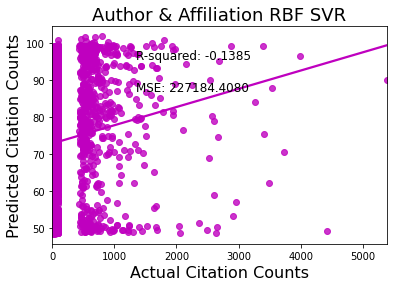

<Figure size 432x288 with 0 Axes>

In [15]:
# Do RBF Versions of A model
print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_A, y_train_A)

# Apply model to test data and quantify model performance
y_test_fit_A = pipe.predict(X_test_A)
score_A = r2_score(y_test_A, y_test_fit_A)
mse_A = mean_squared_error(y_test_A, y_test_fit_A)
print("R-squared:", score_A)
print("MSE:", mse_A)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_A, y_test_fit_A, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_A), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_A), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Author & Affiliation RBF SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrAffiliationC1_rbf.png')
plt.show()
plt.clf()

Running Pipeline
R-squared: -0.12237375995121069
MSE: 223959.99367217015


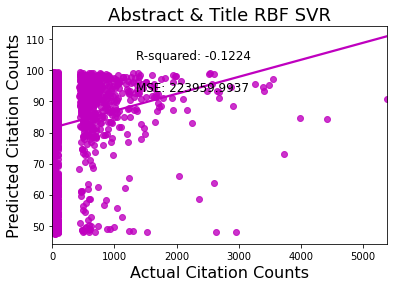

<Figure size 432x288 with 0 Axes>

In [16]:
# RBF version of P model
print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_P, y_train_P)

# Apply model to test data and quantify model performance
y_test_fit_P = pipe.predict(X_test_P)
score_P = r2_score(y_test_P, y_test_fit_P)
mse_P = mean_squared_error(y_test_P, y_test_fit_P)
print("R-squared:", score_P)
print("MSE:", mse_P)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_P, y_test_fit_P, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_P), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_P), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Abstract & Title RBF SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrPaperC1_rbf.png')
plt.show()
plt.clf()

Running Pipeline
R-squared: -0.12331343618070623
MSE: 224147.49795097733


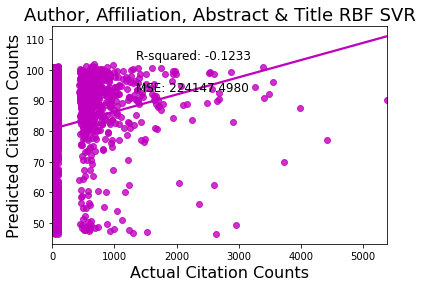

<Figure size 432x288 with 0 Axes>

In [17]:
# RBF version of AP model
print('Running Pipeline')
pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1., epsilon=.1, max_iter=15000))
pipe.fit(X_train_AP, y_train_AP)

# Apply model to test data and quantify model performance
y_test_fit_AP = pipe.predict(X_test_AP)
score_AP = r2_score(y_test_AP, y_test_fit_AP)
mse_AP = mean_squared_error(y_test_AP, y_test_fit_AP)
print("R-squared:", score_AP)
print("MSE:", mse_AP)

# Plot results, compare true citation counts of testing data with the model's predictions
ax = sns.regplot(y_test_AP, y_test_fit_AP, ci=None, color='m')
plt.text(0.25, 0.85, "R-squared: %2.4f"%(score_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)#transform=ax.transAxes, then between 0, 1
plt.text(0.25, 0.7, "MSE: %2.4f"%(mse_AP), horizontalalignment='left', size='large', color='black', transform=ax.transAxes)
plt.title('Author, Affiliation, Abstract & Title RBF SVR', fontsize=18)
plt.ylabel('Predicted Citation Counts', fontsize=16)
plt.xlabel('Actual Citation Counts', fontsize=16)
plt.savefig('svrAffiliationPaperC1_rbf.png')
plt.show()
plt.clf()